<a href="https://colab.research.google.com/github/Spycsh/DataScienceNoteBooks/blob/main/rdkit_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install RDKit. Takes 2-3 minutes
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2020-12-03 16:16:36--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2020-12-03 16:16:36--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.3-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  84.75M   142MB/s    in 0.6s    

2020-12-03 16:16:36 (142 MB/s) - ‘Minicon

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
import numpy as np
import pandas as pd

In [20]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

m = Chem.MolFromSmiles('[O-][Cl+3]([O-])([O-])[O-].c1ccc(-c2[nH]c[n+](CC3CO3)c2-c2ccccc2)cc1')
print(m.GetNumAtoms())

ModuleNotFoundError: ignored

In [ ]:
# https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html
# compute molecular descriptors
import rdkit.Chem.rdMolDescriptors as d
print(d.CalcExactMolWt(m))  # returns the molecule’s exact molecular weight
# https://www.rdkit.org/docs/source/rdkit.Chem.Fragments.html
# functions to match a bunch of fragment descriptors from a file
import rdkit.Chem.Fragments as f
print(f.fr_COO(m)) # Number of aliphatic carboxylic acids
# https://www.rdkit.org/docs/source/rdkit.Chem.Lipinski.html
# Calculation of Lipinski parameters for molecules
import rdkit.Chem.Lipinski as l
print(l.HeavyAtomCount(m)) # Number of heavy atoms (any atom that is not hydrogen) a molecule.
# A special class of features is the so-called fingerprints, which represent presence or absence of substructures. They can be derived in many different ways. 
# One of these that is included in RDKit is the so-called Morgan fingerprints, 
# Here, the second argument corresponds to the size of the substructures
# and the third argument corresponds to how many dimensions to map the 
# substructures to (length of the bit vector)
# which can be generated as follows:
from rdkit.Chem import AllChem
fp = AllChem.GetMorganFingerprintAsBitVect(m,2,nBits=124)
print(np.array(fp))

376.08259932400006
0
26
[0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0
 0 0 1 1 0 1 0 1 0 0 0 1 0]


The task should include

1. what alternative representations (choice of feature sets and data preparation techniques) and learning algorithms (including parameter settings) have been evaluated (at least two different representations and two different algorithms have to be evaluated), and possibly also what approaches to combine multiple models and feature sets have been evaluated. Provide pointers to all external packages that you have used.

2. what method has been employed to choose model and what model has been chosen, what method has been used to provide an estimate for the AUC and what is the estimate for the chosen model.

In [ ]:
# read the dataset 
train_df = pd.read_csv("training_smiles.csv")
train_df.head(5)

,INDEX,SMILES,ACTIVE
0,1,CC#CCCCC(=O)Nc1ccccc1C(=O)O,0.0
1,2,[O-][Cl+3]([O-])([O-])[O-].c1ccc(-c2[nH]c[n+](...,0.0
2,3,CCOC(=O)CSc1nnc(NC(=O)c2cccc([N+](=O)[O-])c2C)s1,0.0
3,4,O=C(CN1CCN(S(=O)(=O)c2ccccc2)CC1)Nc1ccc(Cl)c(C...,0.0
4,5,Cc1cc(NN/C=C2\C=CC(=O)C=C2O)nc(N2CCOCC2)n1,0.0


**Extract features**

* CalcExactMolWt
* HeavyAtomCount
* fr_COO
* MFbitV_x

potential features
* number of atoms
* molecule weights
* fragments
* Lipinski parameters
* Morgan fingerpints(substructures)

## Feature extracting

For quick start, just skip this section and read the 
train_new_features.csv (which has already saved after execeuting
this section)

In [ ]:
train_df["HeavyAtomCount"] = train_df["SMILES"].apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
train_df["CalcExactMolWt"] = train_df["SMILES"].apply(lambda x: d.CalcExactMolWt(Chem.MolFromSmiles(x)))
train_df["fr_COO"] = train_df["SMILES"].apply(lambda x: f.fr_Al_COO(Chem.MolFromSmiles(x)))

RDKit WARNING: [18:23:11] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:23:26] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:23:43] WARNING: not removing hydrogen atom without neighbors


In [ ]:
train_df

,INDEX,SMILES,ACTIVE,HeavyAtomCount,CalcExactMolWt,fr_COO
0,1,CC#CCCCC(=O)Nc1ccccc1C(=O)O,0.0,18,245.105193,0
1,2,[O-][Cl+3]([O-])([O-])[O-].c1ccc(-c2[nH]c[n+](...,0.0,26,376.082599,0
2,3,CCOC(=O)CSc1nnc(NC(=O)c2cccc([N+](=O)[O-])c2C)s1,0.0,25,382.040562,0
3,4,O=C(CN1CCN(S(=O)(=O)c2ccccc2)CC1)Nc1ccc(Cl)c(C...,0.0,27,427.052418,0
4,5,Cc1cc(NN/C=C2\C=CC(=O)C=C2O)nc(N2CCOCC2)n1,0.0,24,329.148789,0
...,...,...,...,...,...,...
121369,121370,O=C(NCc1cccs1)C1CCCN(S(=O)(=O)c2cnc[nH]2)C1,0.0,23,354.082032,0
121370,121371,COc1ccc(Cn2nc(C)cc2C)cc1OC,0.0,18,246.136828,0
121371,121372,Cc1ccc(-c2nn(-c3cc(Cl)ccc3[N+](=O)[O-])c(=O)c3...,0.0,29,405.088019,0
121372,121373,O=C(OCCN1C(=O)c2ccccc2C1=O)c1cccc(OC(F)F)c1,0.0,26,361.076179,0


In [ ]:
## just for test
# kk = train_df.copy()
# for i in range(124):
#   kk["MFbitV_"+str(i)] = 0
# # kk.iloc[:5, 6:] 5*124
# x = train_df["SMILES"].iloc[:5].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x),2,nBits=124))
# # x[0].tolist()
# lists = []
# for i in x:
#   lists += np.array(i).tolist()
# # lists
# # pd.DataFrame((np.array(lists).reshape(5,124)))
# kk.iloc[:5,6:] = np.array(lists).reshape(5,124)
# kk

In [ ]:
for i in range(124):
  train_df["MFbitV_"+str(i)] = 0

print("wait 5 minutes please...")
# 121374*124 MF vector
# MF_x = train_df["SMILES"].apply(lambda x: np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x),2,nBits=124)))

# 124 columns ECFP
MF_x = train_df["SMILES"].apply(lambda x: np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x),2,nBits=124, useFeatures=True)))


# vector_lists = []
# # concat the lists
# for i in MF_x:
#   vector_lists += np.array(i).tolist()
import itertools
vector_lists = list(itertools.chain(*MF_x))

wait 5 minutes please...


KeyboardInterrupt: ignored

In [ ]:
train_df.iloc[:,6:] = np.array(vector_lists).reshape(len(train_df),124)

In [ ]:
train_df.to_csv('train_new_features.csv', index=False)

NameError: ignored

In [ ]:
train_df.head(6)

,INDEX,SMILES,ACTIVE,HeavyAtomCount,CalcExactMolWt,fr_COO,MFbitV_0,MFbitV_1,MFbitV_2,MFbitV_3,MFbitV_4,MFbitV_5,MFbitV_6,MFbitV_7,MFbitV_8,MFbitV_9,MFbitV_10,MFbitV_11,MFbitV_12,MFbitV_13,MFbitV_14,MFbitV_15,MFbitV_16,MFbitV_17,MFbitV_18,MFbitV_19,MFbitV_20,MFbitV_21,MFbitV_22,MFbitV_23,MFbitV_24,MFbitV_25,MFbitV_26,MFbitV_27,MFbitV_28,MFbitV_29,MFbitV_30,MFbitV_31,MFbitV_32,MFbitV_33,...,MFbitV_84,MFbitV_85,MFbitV_86,MFbitV_87,MFbitV_88,MFbitV_89,MFbitV_90,MFbitV_91,MFbitV_92,MFbitV_93,MFbitV_94,MFbitV_95,MFbitV_96,MFbitV_97,MFbitV_98,MFbitV_99,MFbitV_100,MFbitV_101,MFbitV_102,MFbitV_103,MFbitV_104,MFbitV_105,MFbitV_106,MFbitV_107,MFbitV_108,MFbitV_109,MFbitV_110,MFbitV_111,MFbitV_112,MFbitV_113,MFbitV_114,MFbitV_115,MFbitV_116,MFbitV_117,MFbitV_118,MFbitV_119,MFbitV_120,MFbitV_121,MFbitV_122,MFbitV_123
0,1,CC#CCCCC(=O)Nc1ccccc1C(=O)O,0.0,18,245.105193,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1
1,2,[O-][Cl+3]([O-])([O-])[O-].c1ccc(-c2[nH]c[n+](...,0.0,26,376.082599,0,1,0,1,0,1,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,3,CCOC(=O)CSc1nnc(NC(=O)c2cccc([N+](=O)[O-])c2C)s1,0.0,25,382.040562,0,1,1,1,0,1,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1
3,4,O=C(CN1CCN(S(=O)(=O)c2ccccc2)CC1)Nc1ccc(Cl)c(C...,0.0,27,427.052418,0,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1
4,5,Cc1cc(NN/C=C2\C=CC(=O)C=C2O)nc(N2CCOCC2)n1,0.0,24,329.148789,0,1,1,1,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0
5,6,Cc1ccc(C2=NN(S(C)(=O)=O)C(c3cccs3)C2)cc1,0.0,21,320.065320,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


skip the above section, directly read the training_preparation.csv in which features have already been
extracted.

In [ ]:
train_df = pd.read_csv('train_new_features.csv')

## Data preprocessing
* column filter
* imputation
* normalization
* discretization
* train test split

In [ ]:
from sklearn import model_selection
df_X = train_df.drop(columns=['INDEX','SMILES','ACTIVE'])
y = train_df['ACTIVE']

Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.

This is because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage. Using any information coming from the test set before or during training is a potential bias in the evaluation of the performance

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df_X, y, test_size=0.2, random_state=1) # set the random state
y_train.head()

27745    0.0
4208     0.0
22527    0.0
7579     0.0
32382    0.0
Name: ACTIVE, dtype: float64

In [ ]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.preprocessing import KBinsDiscretizer
kbd = KBinsDiscretizer(n_bins=10, encode="ordinal")

In [ ]:
# save the indexes
train_indexes = X_train.index
test_indexes = X_test.index

In [ ]:
X_train = imp_mean.fit_transform(X_train)
X_train[:,[0,1]] = scaler.fit_transform(X_train[:,[0,1]])
X_train[:,[0,1]] = kbd.fit_transform(X_train[:,[0,1]])
X_train = pd.DataFrame(X_train, columns=df_X.columns, index=train_indexes)
X_train
# df_X = scaler.fit_transform(X_train)
# df_X = kbd.fit_transform(df_X)
# pd.DataFrame(df_X)

,HeavyAtomCount,CalcExactMolWt,fr_COO,MFbitV_0,MFbitV_1,MFbitV_2,MFbitV_3,MFbitV_4,MFbitV_5,MFbitV_6,MFbitV_7,MFbitV_8,MFbitV_9,MFbitV_10,MFbitV_11,MFbitV_12,MFbitV_13,MFbitV_14,MFbitV_15,MFbitV_16,MFbitV_17,MFbitV_18,MFbitV_19,MFbitV_20,MFbitV_21,MFbitV_22,MFbitV_23,MFbitV_24,MFbitV_25,MFbitV_26,MFbitV_27,MFbitV_28,MFbitV_29,MFbitV_30,MFbitV_31,MFbitV_32,MFbitV_33,MFbitV_34,MFbitV_35,MFbitV_36,...,MFbitV_84,MFbitV_85,MFbitV_86,MFbitV_87,MFbitV_88,MFbitV_89,MFbitV_90,MFbitV_91,MFbitV_92,MFbitV_93,MFbitV_94,MFbitV_95,MFbitV_96,MFbitV_97,MFbitV_98,MFbitV_99,MFbitV_100,MFbitV_101,MFbitV_102,MFbitV_103,MFbitV_104,MFbitV_105,MFbitV_106,MFbitV_107,MFbitV_108,MFbitV_109,MFbitV_110,MFbitV_111,MFbitV_112,MFbitV_113,MFbitV_114,MFbitV_115,MFbitV_116,MFbitV_117,MFbitV_118,MFbitV_119,MFbitV_120,MFbitV_121,MFbitV_122,MFbitV_123
27745,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4208,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22527,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7579,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32382,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50057,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
98047,4.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5192,5.0,5.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
77708,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0

In [ ]:
X_test = imp_mean.fit_transform(X_test)
X_test[:,[0,1]] = scaler.fit_transform(X_test[:,[0,1]])
X_test[:,[0,1]] = kbd.fit_transform(X_test[:,[0,1]])
X_test = pd.DataFrame(X_test, columns=df_X.columns, index=test_indexes)
X_test

,HeavyAtomCount,CalcExactMolWt,fr_COO,MFbitV_0,MFbitV_1,MFbitV_2,MFbitV_3,MFbitV_4,MFbitV_5,MFbitV_6,MFbitV_7,MFbitV_8,MFbitV_9,MFbitV_10,MFbitV_11,MFbitV_12,MFbitV_13,MFbitV_14,MFbitV_15,MFbitV_16,MFbitV_17,MFbitV_18,MFbitV_19,MFbitV_20,MFbitV_21,MFbitV_22,MFbitV_23,MFbitV_24,MFbitV_25,MFbitV_26,MFbitV_27,MFbitV_28,MFbitV_29,MFbitV_30,MFbitV_31,MFbitV_32,MFbitV_33,MFbitV_34,MFbitV_35,MFbitV_36,...,MFbitV_84,MFbitV_85,MFbitV_86,MFbitV_87,MFbitV_88,MFbitV_89,MFbitV_90,MFbitV_91,MFbitV_92,MFbitV_93,MFbitV_94,MFbitV_95,MFbitV_96,MFbitV_97,MFbitV_98,MFbitV_99,MFbitV_100,MFbitV_101,MFbitV_102,MFbitV_103,MFbitV_104,MFbitV_105,MFbitV_106,MFbitV_107,MFbitV_108,MFbitV_109,MFbitV_110,MFbitV_111,MFbitV_112,MFbitV_113,MFbitV_114,MFbitV_115,MFbitV_116,MFbitV_117,MFbitV_118,MFbitV_119,MFbitV_120,MFbitV_121,MFbitV_122,MFbitV_123
31170,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
59201,8.0,8.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
74232,5.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
65448,2.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2458,6.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
100894,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
111780,3.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
37755,9.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

In [ ]:
# add
# extract the first three features
X_train_3 = X_train.iloc[:, [0,1,2]]
X_test_3 = X_test.iloc[:,[0,1,2]]

## Building Models
* Naive Bayes (BernoulliNB)
* DecisionTree
* RandomForest
* MLPClassifier(NN)


In [ ]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
prediction_bnb = bnb.predict_proba(X_test)

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
prediction_gnb = gnb.predict_proba(X_test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
prediction_mnb = mnb.predict_proba(X_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
prediction_dtc = dtc.predict_proba(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
prediction_rfc = rfc.predict_proba(X_test)

NameError: ignored

In [ ]:
# add 
# the first three features
from sklearn.ensemble import RandomForestClassifier
rfc2 = RandomForestClassifier()
rfc2.fit(X_train_3, y_train)
prediction_rfc = rfc2.predict_proba(X_test_3)

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
prediction_mlp = mlp.predict_proba(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



# Evaluation process



In [ ]:
def calAUC(prob, labels):
    '''
    calculate the auc and return
    :param prob: the probability ndarray that predict as Positive
    :param labels: the real labels，in which 1 represent Positive，0 represent Negtive
    :return: AUC
    '''
    
    f = list(zip(prob,labels))
    
    rank = [values2 for values1,values2 in sorted(f,key = lambda x:x[0])]
    
    rankList = [i+1 for i in range(len(rank)) if rank[i] == 1]
    # get the rank
    posNum = 0
    negNum = 0
    for i in range(len(labels)):
        if(labels[i] == 1):
            posNum += 1
        else:
            negNum += 1
    # calculate the AUC
    auc = (sum(rankList) - (posNum*(posNum+1))/2)/(posNum*negNum)
    return auc

In [ ]:
# use the models to predict the column that represent the probability positive
bnb_result = bnb.predict_proba(X_test)[:,1]
gnb_result = gnb.predict_proba(X_test)[:,1]
mnb_result = mnb.predict_proba(X_test)[:,1]
dtc_result = dtc.predict_proba(X_test)[:,1]
rfc_result = rfc.predict_proba(X_test)[:,1]
mlp_result = mlp.predict_proba(X_test)[:,1]

model_results = [bnb_result, gnb_result, mnb_result, dtc_result, rfc_result, mlp_result]
model_names = ['bnb', 'gnb', 'mnb', 'dtc', 'rfc', 'mlp']

In [ ]:
rfc_result = rfc.predict_proba(X_test)[:,1]
calAUC(rfc_result, np.array(y_test))

0.7967238283337637

In [ ]:
for i, model_result in enumerate(model_results):
  print(model_names[i] + " has an AUC of: " + str(calAUC(model_result, np.array(y_test)))

bnb has an AUC of: 0.6413939140550198
gnb has an AUC of: 0.6299408575710143
mnb has an AUC of: 0.6452334749686238
dtc has an AUC of: 0.5835687612528365
rfc has an AUC of: 0.7779033843989817
mlp has an AUC of: 0.7088053672775972


Inbalance of data exists...

In [ ]:
train_df["ACTIVE"].value_counts()

0.0    109382
1.0     11992
Name: ACTIVE, dtype: int64

cross validation

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
kf = KFold(n_splits=5, random_state=42, shuffle=False)
# rf = RandomForestClassifier(n_estimators=100)
# cross_val_score(rf, X_train, y_train, cv=kf, scoring='roc_auc')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Use GridSearchCV to find the best parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier()

params = {
    'n_estimators':[50,100,200],
    'max_depth':[5,10,15,20,30],
    'random_state':[0]
}

# training times will take (3*5)*5 = 75 
grid_search = GridSearchCV(rfc, param_grid=params, cv=kf, scoring='roc_auc')

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_sco

In [ ]:
grid_search.best_params_

{'max_depth': 30, 'n_estimators': 200, 'random_state': 0}

In [ ]:
sorted(grid_search.best_estimator_.feature_importances_)

In [ ]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
rfc_updated = RandomForestClassifier(max_depth=30, n_estimators=200)
rfc_updated.fit(X_train, y_train)
prediction_rfc_updated = rfc_updated.predict_proba(X_test)

In [ ]:
print("The random forest classifier with a grid search has an AUC of: " + str(calAUC(prediction_rfc_updated[:, 1], np.array(y_test))))

The random forest classifier with a grid search has an AUC of: 0.8051196823611918


# Ensembled Method

In [ ]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('mnb',mnb), ('rfc',rfc), ('mlp',mlp)],
    voting='soft'
)
# voting_clf.fit(X_train, y_train)

In [ ]:

from sklearn.metrics import accuracy_score
for clf in (mnb, rfc, mlp, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict_proba(X_test)
  print(clf.__class__.__name__, calAUC(y_pred[:, 1], np.array(y_test)))

MultinomialNB 0.6452334749686238
RandomForestClassifier 0.7871879160546313


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier 0.7093962739736694


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


VotingClassifier 0.7717161107786665


# Apply the model on the test data

In [ ]:
test_df = pd.read_csv('test_smiles.csv')
test_df_copy = test_df.copy()

test_df_copy["HeavyAtomCount"] = test_df_copy["SMILES"].apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
test_df_copy["CalcExactMolWt"] = test_df_copy["SMILES"].apply(lambda x: d.CalcExactMolWt(Chem.MolFromSmiles(x)))
test_df_copy["fr_COO"] = test_df_copy["SMILES"].apply(lambda x: f.fr_Al_COO(Chem.MolFromSmiles(x)))

test_df_copy

RDKit WARNING: [18:52:50] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:52:55] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:53:00] WARNING: not removing hydrogen atom without neighbors


,INDEX,SMILES,HeavyAtomCount,CalcExactMolWt,fr_COO
0,121375,Cc1ccc(-c2csc(NC(=O)C3=NN(c4ccccc4)C(=O)CC3)n2...,28,390.115047,0
1,121376,O=C(Nc1ccccc1)N1CC[C@@]2(CCCN(C(=O)c3cccc(F)c3...,28,381.185255,0
2,121377,CC(=O)N1C(=O)N(C(C)=O)C2C1N(C)C(=O)N2C(C)=O,20,282.096420,0
3,121378,CCOC(=O)Cn1/c(=N/C(=O)c2ccc([N+](=O)[O-])s2)sc...,26,391.029663,0
4,121379,Cc1ccc(S(=O)(=O)N2CCC(C(=O)Nc3nnc(C45CC6CC(CC(...,34,500.191583,0
...,...,...,...,...,...
40453,161828,O=C(CSc1nnc(-c2ccncc2)o1)N1CCc2ccccc2C1,25,352.099397,0
40454,161829,N=c1sccn1CC(=O)Nc1ccc(Cl)c(S(=O)(=O)N2CCOCC2)c1,26,416.037975,0
40455,161830,CC(/C=C/c1ccc2c(c1)OCO2)=N\NC(=O)c1cccc([N+](=...,26,353.101171,0
40456,161831,CC(C)Cn1c(=O)c(C(=O)Nc2cnccn2)c(O)c2ccccc21,25,338.137890,0


In [ ]:
for i in range(124):
  test_df_copy["MFbitV_"+str(i)] = 0

print("wait 5 minutes please...")
# 40458*124 MF vector
MF_x_test = test_df_copy["SMILES"].apply(lambda x: np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x),2,nBits=124)))

# vector_lists = []
# # concat the lists
# for i in MF_x:
#   vector_lists += np.array(i).tolist()
import itertools
vector_lists_test = list(itertools.chain(*MF_x_test))

test_df_copy.iloc[:,5:] = np.array(vector_lists_test).reshape(len(test_df_copy),124)

wait 5 minutes please...


RDKit WARNING: [18:53:39] WARNING: not removing hydrogen atom without neighbors


In [ ]:
test_df_data = test_df_copy.drop(columns=['INDEX','SMILES'])

In [ ]:
_X_test = np.array(test_df_data)
_X_test[:,[0,1]] = scaler.fit_transform(_X_test[:,[0,1]])
_X_test[:,[0,1]] = kbd.fit_transform(_X_test[:,[0,1]])
_X_test = pd.DataFrame(_X_test, columns=test_df_data.columns, index=test_df_copy.index)
_X_test

,HeavyAtomCount,CalcExactMolWt,fr_COO,MFbitV_0,MFbitV_1,MFbitV_2,MFbitV_3,MFbitV_4,MFbitV_5,MFbitV_6,MFbitV_7,MFbitV_8,MFbitV_9,MFbitV_10,MFbitV_11,MFbitV_12,MFbitV_13,MFbitV_14,MFbitV_15,MFbitV_16,MFbitV_17,MFbitV_18,MFbitV_19,MFbitV_20,MFbitV_21,MFbitV_22,MFbitV_23,MFbitV_24,MFbitV_25,MFbitV_26,MFbitV_27,MFbitV_28,MFbitV_29,MFbitV_30,MFbitV_31,MFbitV_32,MFbitV_33,MFbitV_34,MFbitV_35,MFbitV_36,...,MFbitV_84,MFbitV_85,MFbitV_86,MFbitV_87,MFbitV_88,MFbitV_89,MFbitV_90,MFbitV_91,MFbitV_92,MFbitV_93,MFbitV_94,MFbitV_95,MFbitV_96,MFbitV_97,MFbitV_98,MFbitV_99,MFbitV_100,MFbitV_101,MFbitV_102,MFbitV_103,MFbitV_104,MFbitV_105,MFbitV_106,MFbitV_107,MFbitV_108,MFbitV_109,MFbitV_110,MFbitV_111,MFbitV_112,MFbitV_113,MFbitV_114,MFbitV_115,MFbitV_116,MFbitV_117,MFbitV_118,MFbitV_119,MFbitV_120,MFbitV_121,MFbitV_122,MFbitV_123
0,7.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,7.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,6.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40453,6.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
40454,6.0,8.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
40455,6.0,5.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
40456,6.0,4.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,

In [ ]:
# use the model to predict the data
prediction_test_data = rfc_updated.predict(_X_test)
test_df["predicted_ACTIVE"] = prediction_test_data
test_df.to_csv("predicted_result.csv", index=False)

In [ ]:
import xgboost as xgb


In [ ]:
# X_train_xx = xgb.DMatrix(X_train)
# y_train_xx = xgboost.DMatrix(y_train)
# X_test_xx = xgboost.DMatrix(X_test)
# y_test_xx = xgboost.DMatrix(y_test)

# load data
dtrain=xgb.DMatrix(X_train,label=y_train)
dtest=xgb.DMatrix(X_test)

# specify parameters via map
param = {
    'eta':0.1, 
    'objective': 'multi:softmax',  # multi-classification
    'num_class': 3,                # nums of classes
    'gamma': 0.2,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 12,               # 构建树的深度，越大越容易过拟合
    'lambda': 3,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.8}
num_round = 10
bst = xgb.train(param, dtrain, num_round)
# make prediction
y_pred = bst.predict(dtest)

KeyboardInterrupt: ignored

In [ ]:
print("XGboost AUC: " + str(calAUC(y_pred, np.array(y_test))))

XGboost AUC: 0.693693656633227


In [ ]:
# xgboost from sklearn implement
from xgboost import XGBClassifier

xgbt_clf = XGBClassifier(objective='multi:softmax',
                         num_class=2)
xgbt_clf.fit(X_train, y_train)
y_pred_ = xgbt_clf.predict(X_test)
print("XGboost AUC: " + str(calAUC(y_pred_, np.array(y_test))))

XGboost AUC: 0.4999742168767402


# a try on DNN

In [ ]:
import tensorflow as tf
# https://stackoverflow.com/questions/55550396/how-to-use-tf-estimator-dnnclassifier-scikit-flow

def train_input_fn(features, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    return dataset.shuffle(1000).repeat().batch(batch_size)

feature_columns = [tf.feature_column.numeric_column(key = key) for key in X_train.columns]
dnn_clf = tf.estimator.DNNClassifier(hidden_units=[30, 10], feature_columns=feature_columns, n_classes=2)
dnn_clf.train(input_fn=lambda: train_input_fn(X_train, y_train, 50), steps=4000)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp5flyx75e', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. 

In [ ]:
X_test

In [ ]:
# predict_input_fn = train_input_fn(X_test, y_test, 50)
# y_out_prob=dnn_clf.predict(input_fn=predict_input_fn,predict_keys="probabilities")

eval_result = dnn_clf.evaluate(
    input_fn=lambda: input_fn(X_test, y_test, training=False))

eval_result

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-12-03T01:12:36Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp5flyx75e/model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 2.47962s
INFO:tensorflow:Finished evaluation at 2020-12-03-01:12:39
INFO:tensorflow:Saving dict for global step 4000: accuracy = 0.90265703, accura

{'accuracy': 0.90265703,
 'accuracy_baseline': 0.90265703,
 'auc': 0.4963569,
 'auc_precision_recall': 0.09737787,
 'average_loss': 0.32938632,
 'global_step': 4000,
 'label/mean': 0.097342946,
 'loss': 0.32935828,
 'precision': 0.0,
 'prediction/mean': 0.11172689,
 'recall': 0.0}

In [ ]:
def input_fn(features, labels, training=True, batch_size=256):
    """An input function for training or evaluating"""
    # 将输入转换为数据集。
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # 如果在训练模式下混淆并重复数据。
    if training:
        dataset = dataset.shuffle(1000).repeat()

    return dataset.batch(batch_size)

# Analyze the importance of the fingerprint bits 

In [ ]:
fp_list = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x),2,nBits=124, useFeatures=False) for x in train_df["SMILES"]]


RDKit WARNING: [14:18:33] WARNING: not removing hydrogen atom without neighbors


In [ ]:
len(fp_list[0])

124

In [ ]:
from rdkit.ML import InfoTheory
ranker = InfoTheory.InfoBitRanker(124, 2) # 124 bits, 2 classes, default infoType rdInfoTheory.InfoType.ENTROPY
for i, fp in enumerate(fp_list):
  act = int(train_df["ACTIVE"][i])
  ranker.AccumulateVotes(fp, act)
top50 = ranker.GetTopN(50)

saved_indexes = []

for id, gain, n0, n1 in top50:
  saved_indexes.append(id)
  print(int(id),'%.3f'%gain,int(n0),int(n1))

We can infer that bit 58,46,30,66,15,68,3,121 of the fingerprint have importance on module activity

In [ ]:
new_train_df = pd.read_csv('train_new_features.csv')
new_train_df.drop(columns=[('MFbitV_'+str(i)) for i in range(124) if i not in saved_indexes], inplace=True)

NameError: ignored

In [ ]:
from sklearn import model_selection
df_X = new_train_df.drop(columns=['INDEX','SMILES','ACTIVE'])
y = new_train_df['ACTIVE']

print("train test set split...")

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df_X, y, test_size=0.2, random_state=1) # set the random state

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.preprocessing import KBinsDiscretizer
kbd = KBinsDiscretizer(n_bins=10, encode="ordinal")


train_indexes = X_train.index
test_indexes = X_test.index

print("normalize and discretize the data...")

X_train = imp_mean.fit_transform(X_train)
X_train[:,[0,1]] = scaler.fit_transform(X_train[:,[0,1]])
X_train[:,[0,1]] = kbd.fit_transform(X_train[:,[0,1]])
X_train = pd.DataFrame(X_train, columns=df_X.columns, index=train_indexes)

X_test = imp_mean.fit_transform(X_test)
X_test[:,[0,1]] = scaler.fit_transform(X_test[:,[0,1]])
X_test[:,[0,1]] = kbd.fit_transform(X_test[:,[0,1]])
X_test = pd.DataFrame(X_test, columns=df_X.columns, index=test_indexes)

print("build the random forest classifier with best parameters")
rfc = RandomForestClassifier(max_depth=30, n_estimators=200)
rfc.fit(X_train, y_train)
prediction_rfc = rfc.predict_proba(X_test)

from sklearn.svm import SVC
svc=SVC()
svc.fit(X_train, y_train)
prediction_svc = svc.predict_proba(X_test)

print("build the MLP classifier with best parameters")
from sklearn.svm import SVC

print("calculate the AUC...")

print("The random forest classifier with a grid search and lower dimensions has an AUC of: "
 + str(calAUC(prediction_rfc[:, 1], np.array(y_test))))

print("The svc classifier with lower dimensions has an AUC of: "
 + str(calAUC(prediction_svc[:, 1], np.array(y_test))))

train test set split...
normalize and discretize the data...
build the random forest classifier with best parameters


# add 3D descriptor

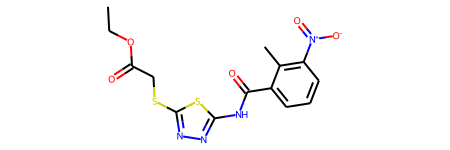

In [ ]:
m = Chem.MolFromSmiles('CCOC(=O)CSc1nnc(NC(=O)c2cccc([N+](=O)[O-])c2C)s1')
m

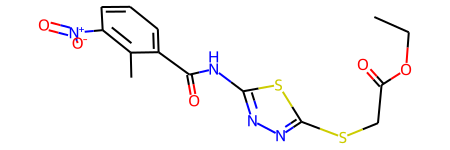

In [ ]:
from rdkit.Chem.Descriptors import rdMolDescriptors

def calc_dragon_type_desc(mol):
 return rdMolDescriptors.CalcAUTOCORR3D(mol) + rdMolDescriptors.CalcMORSE(mol) + \
        rdMolDescriptors.CalcRDF(mol) + rdMolDescriptors.CalcWHIM(mol)
# Chem.AddHs(m)
AllChem.EmbedMolecule(m) 
m

In [ ]:
train_df_copy = train_df.copy()

calc3Dlist = []
for i,x in enumerate(train_df_copy["SMILES"]):
  print(i)
  xx = Chem.MolFromSmiles(x)
  Chem.AddHs(xx) 
  AllChem.EmbedMolecule(xx)
  calc3Dlist.append(xx)
  
calc3Dlist
# train_df_copy["SMILES"].apply(lambda x: AllChem.EmbedMolecule(Chem.MolFromSmiles(x)))
# train_df_copy["3D_descriptor"] = [calc_dragon_type_desc(x) for x in train_df_copy["SMILES"]]
# train_df_copy

NameError: ignored